# Техническая часть

In [1]:
#!pip3 -qq install torch==0.4.1
#!pip -qq install torchtext==0.3.1

#!pip -qq install spacy==2.0.16
#!python -m spacy download en
!pip install sacremoses==0.0.5
#!pip install subword_nmt==0.3.5
!wget -qq http://www.manythings.org/anki/rus-eng.zip 
!unzip rus-eng.zip

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [0]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    DEVICE = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    DEVICE = torch.device('cpu')

np.random.seed(42)

import warnings

warnings.filterwarnings('ignore')

## Подготовка данных

In [3]:
!shuf -n 10 rus.txt

I'd love to see inside Tom's house.	Мне бы хотелось увидеть дом Тома изнутри.	CC-BY 2.0 (France) Attribution: tatoeba.org #1096181 (CK) & #7021710 (odexed)
I wasn't complaining.	Я не жаловался.	CC-BY 2.0 (France) Attribution: tatoeba.org #5858495 (CK) & #5913976 (marafon)
I thought this was important.	Я думал, что это важно.	CC-BY 2.0 (France) Attribution: tatoeba.org #2543229 (CK) & #3514060 (odexed)
I drink tea, too.	Я тоже пью чай.	CC-BY 2.0 (France) Attribution: tatoeba.org #3378130 (CK) & #4874433 (venticello)
I had trouble parking.	У меня были проблемы с парковкой.	CC-BY 2.0 (France) Attribution: tatoeba.org #7878163 (CK) & #7893655 (marafon)
It's in your bag.	Оно в Вашей сумке.	CC-BY 2.0 (France) Attribution: tatoeba.org #5790191 (Eccles17) & #5791193 (marafon)
Tom was perfect.	Том был безупречен.	CC-BY 2.0 (France) Attribution: tatoeba.org #4471306 (Hybrid) & #5797112 (marafon)
I'll just check.	Я только проверю.	CC-BY 2.0 (France) Attribution: tatoeba.org #2247765 (CK) & #26071

In [0]:
import spacy
from torchtext.data import Field, Example, Dataset, BucketIterator

spacy_en = spacy.load('en')
BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

source_field = Field(tokenize='spacy', init_token=None, eos_token=EOS_TOKEN, lower=True)
target_field = Field(tokenize='moses', init_token=BOS_TOKEN, eos_token=EOS_TOKEN, lower=True)
fields = [('source', source_field), ('target', target_field)]

In [7]:
from tqdm import tqdm

MAX_TOKENS_COUNT = 16
SUBSET_SIZE = .3

examples = []
with open('rus.txt') as f:
    for line in tqdm(f, total=328190):
        source_text, target_text, _ = line.split('\t')
        source_text = source_field.preprocess(source_text)
        target_text = target_field.preprocess(target_text)
        if len(source_text) <= MAX_TOKENS_COUNT and len(target_text) <= MAX_TOKENS_COUNT:
            if np.random.rand() < SUBSET_SIZE:
                examples.append(Example.fromlist([source_text, target_text], fields))

380911it [01:02, 6047.77it/s]


In [8]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

source_field.build_vocab(train_dataset, min_freq=2)
print('Source vocab size =', len(source_field.vocab))

target_field.build_vocab(train_dataset, min_freq=2)
print('Target vocab size =', len(target_field.vocab))

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(32, 512), shuffle=True, device=DEVICE, sort=False
)

Train size = 96658
Test size = 17057
Source vocab size = 6681
Target vocab size = 15231


# Seq2seq with Attention

In [0]:
batch = next(iter(train_iter))

In [0]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1, bidirectional=False):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim, 
                           num_layers=num_layers, bidirectional=bidirectional)

    def forward(self, inputs, hidden=None):
        encoder_output, encoder_hidden = self._rnn(self._emb(inputs), hidden)
        return encoder_output, encoder_hidden

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, attn_dim=128, num_layers=1):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._attention = DotAttention(rnn_hidden_dim, rnn_hidden_dim, attn_dim)
        self._rnn = nn.GRU(input_size=emb_dim + rnn_hidden_dim, 
                           hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out = nn.Linear(rnn_hidden_dim, vocab_size)

    def forward(self, inputs, encoder_output, encoder_mask, hidden=None):
        embs = self._emb(inputs)
        outputs, attentions = [], []
        key_proj = self._attention._key_layer(encoder_output)
        for i in range(embs.shape[0]):
            # encoder_output (seq_len, batch_size, rnn_hidden_dim)
            # hidden (1, batch_size, rnn_hidden_dim)
            context, f_att = self._attention(query=hidden, key_proj=key_proj, 
                                             value=encoder_output, mask=encoder_mask)
            context = context.unsqueeze(0)
            rnn_input = torch.cat((embs[i: i+1], context), -1)
            output, hidden = self._rnn(rnn_input, hidden)
            
            outputs.append(output)
            attentions.append(f_att)
            
        output = torch.cat(outputs)
        attentions = torch.cat(attentions)
        return self._out(output), hidden, attentions

In [0]:
class DotAttention(nn.Module):
    def __init__(self, query_size, key_size, hidden_dim):  # query_size == hidden_dim, 
        # но пусть будет как отдельная переменная, чтобы не переписывать декодер
        super().__init__()
        
        self._key_layer = nn.Linear(key_size, hidden_dim)
        
    def forward(self, query, key_proj, value, mask):
        # key (seq_len, batch_size, rnn_hidden_dim)
        # query (1, batch_size, rnn_hidden_dim)
        
        query = query.permute(1, 2, 0)
        key_proj = key_proj.permute(1, 0, 2)
        f_att = query.new_zeros([key_proj.shape[0], key_proj.shape[1], query.shape[1]])  # (batch_size, seq_len, 1)
        for i in range(key_proj.shape[0]):
            f_att[i] = torch.matmul(key_proj[i], query[i])
        f_att = f_att.permute(1, 0, 2)
        
        f_att.data.masked_fill_(mask.unsqueeze(2), -float('inf'))
        
        # f_att (seq_len, batch_size, 1)
        
        f_att = F.softmax(f_att, 0)
        
        scores = f_att * value
        
        return scores.sum(0), f_att

In [0]:
class TranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=64, rnn_hidden_dim=128, 
                 attn_dim=128, num_layers=1, bidirectional_encoder=False):
        
        super().__init__()
        
        self.encoder = Encoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers, bidirectional_encoder)
        self.decoder = Decoder(target_vocab_size, emb_dim, rnn_hidden_dim, attn_dim, num_layers)
        
    def forward(self, source_inputs, target_inputs):
        encoder_mask = source_inputs == 1
        encoder_output, encoder_hidden = self.encoder(source_inputs)
        
        return self.decoder(target_inputs, encoder_output, encoder_mask, encoder_hidden)

In [17]:
model = TranslationModel(source_vocab_size=len(source_field.vocab),
                         target_vocab_size=len(target_field.vocab)).to(DEVICE)

model(batch.source, batch.target)[0].shape

torch.Size([15, 32, 15231])

## Обучение модели

In [0]:
tqdm.get_lock().locks = []


def do_epoch(model, criterion, data_iter, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):                
                logits, _, _ = model(batch.source, batch.target)
                
                target = torch.cat((batch.target[1:], batch.target.new_ones((1, batch.target.shape[1]))))
                loss = criterion(logits.view(-1, logits.shape[-1]), target.view(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), 
                                                                                         math.exp(loss.item())))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )
            progress_bar.refresh()

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None):
    best_val_loss = None
    all_train_loss = []
    all_val_loss = []
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, optimizer, name_prefix + 'Train:')
        all_train_loss.append(train_loss)
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, None, name_prefix + '  Val:')
            all_val_loss.append(val_loss)


In [24]:
model = TranslationModel(source_vocab_size=len(source_field.vocab),
                         target_vocab_size=len(target_field.vocab)).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=11, val_iter=test_iter)

[11 / 11]   Val: Loss = 1.64146, PPX = 5.16: 100%|██████████| 34/34 [00:17<00:00,  2.00it/s]


## Визуализация

In [0]:
def greedy_decode(model, source_text, source_field, target_field):
    bos_index = target_field.vocab.stoi[BOS_TOKEN]
    eos_index = target_field.vocab.stoi[EOS_TOKEN]
    
    model.eval()
    with torch.no_grad():
        result, attentions = [], []
        source = source_field.preprocess(source_text)
        inputs = source_field.process([source]).to(DEVICE)
        
        encoder_output, encoder_hidden = model.encoder(inputs)
        encoder_mask = torch.zeros_like(inputs).byte()
        
        hidden = encoder_hidden
        step = LongTensor([[bos_index]])
        
        for _ in range(50):
            step, hidden, attention = model.decoder(step, encoder_output, encoder_mask, hidden)
            step = step.argmax(-1)
            attentions.append(attention.squeeze(1))
          
            if step.squeeze().item() == eos_index:
                break
            
            result.append(step.item())   
        result = [target_field.vocab.itos[ind] for ind in result]
        return source, result, torch.cat(attentions, -1).data.cpu().numpy()


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots(figsize=(9, 9))
    heatmap = ax.pcolor(scores, cmap='OrRd')

    ax.set_xticklabels(trg, minor=False)
    ax.set_yticklabels(src, minor=False)

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=True)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

In [57]:
source, result, attentions = greedy_decode(model, "Where do you live ?", source_field, target_field)
print(' '.join(result))

где ты живёшь ?


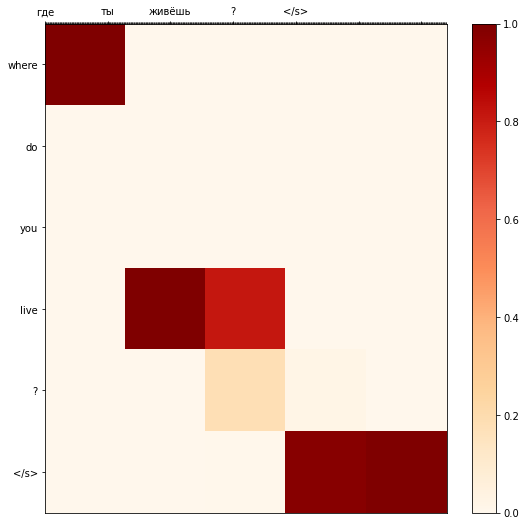

In [93]:
plot_heatmap(source + ['</s>'], result + ['</s>'], attentions)